# Exercise 1
#### Group 25. Maximilian Laurent Heß (12347554), Oleksandra Kravchenko (11935050)

## Reading the data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, CategoricalColorMapper, HoverTool, Legend
from bokeh.models.formatters import CustomJSTickFormatter
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

We have the following data files:
- **players**: information about individual players
- **teams**: general information about NBA teams
- **player_data_per_36_min**: quantitive data about each player's performance in a given season. Players' performance is normalized to 36-minutes-game for more objective comparison regardless of playing time.

In [6]:
players = pd.read_csv("data/players.csv")
teams = pd.read_csv("data/teams.csv")
player_data_per_36_min = pd.read_csv("data/player_data_per_36_min.csv")

## Handling duplicates

In [7]:
print(
    f"Duplicates in player_data_per_36_min.csv: {len(player_data_per_36_min[player_data_per_36_min.duplicated()])}"
)
print(f"Duplicates in players.csv: {len(players[players.duplicated()])}")
print(f"Duplicates in teams.csv: {len(teams[teams.duplicated()])}")

Duplicates in player_data_per_36_min.csv: 0
Duplicates in players.csv: 0
Duplicates in teams.csv: 0


We do not have any complete duplicates in our data. However, we noticed that the player_data_per_36_min dataset contains multiple entries per player_id per season, which does not support our initial assumption about the content of the data. 
After further research in the data source, we found out, that NBA players often switch teams, so many players would have multiple entries for the same season while they played for different teams. Besides, where it is the case, there is also an additional row with the "total" statistics for the player across the teams that matches the same of total games from other 2 entries for the player for different teams. Technically, this behaviour makes the rows with total statistics a duplicate because they do not provide any additional data but only summarize the other entries.

Since we do not have any information about the specific team that any given player's performance is attributed to (there is no team_id column in the player_data_per_36_min dataset), we decided to only keep the "total" statistics (identified by the maximum value of "total_games"). The cells below provide an example.

In [8]:
print(
    f"Partial duplicates in player_data_per_36_min.csv: {len(player_data_per_36_min[player_data_per_36_min.duplicated(["season", "player_id"])])}"
)

Partial duplicates in player_data_per_36_min.csv: 4780


In [9]:
player_data_per_36_min.loc[
    (player_data_per_36_min["player_id"] == 1)
    & (player_data_per_36_min["season"] == "1994-95")
]

,id,player_id,season,total_games,games_started,minutes_played,fg,fga,fgp,fg3,...,ftp,orb,drb,trb,ast,stl,blk,tov,pf,pts
11870,11871,1,1994-95,54.0,0.0,506.0,8.4,16.4,0.511,0.0,...,0.571,2.6,5.5,8.1,0.9,1.1,0.9,3.2,7.4,18.2
11871,11872,1,1994-95,51.0,0.0,476.0,8.8,16.6,0.532,0.0,...,0.571,2.6,5.4,8.0,1.0,1.1,0.9,3.0,7.7,19.2
11872,11873,1,1994-95,3.0,0.0,30.0,1.2,13.2,0.091,0.0,...,NaN,3.6,6.0,9.6,0.0,0.0,0.0,6.0,2.4,2.4


In [10]:
player_data_per_36_min.loc[
    (player_data_per_36_min["player_id"] == 4794)
    & (player_data_per_36_min["season"] == "2018-19")
]

,id,player_id,season,total_games,games_started,minutes_played,fg,fga,fgp,fg3,...,ftp,orb,drb,trb,ast,stl,blk,tov,pf,pts
26067,26068,4794,2018-19,59.0,37.0,1040.0,7.3,13.1,0.559,0.0,...,0.802,4.0,8.6,12.5,2.2,0.5,1.8,2.4,4.7,18.2
26068,26069,4794,2018-19,33.0,12.0,516.0,7.8,13.5,0.580,0.0,...,0.864,3.8,7.5,11.3,1.7,0.3,1.9,2.3,5.1,19.6
26069,26070,4794,2018-19,26.0,25.0,524.0,6.9,12.8,0.538,0.0,...,0.733,4.2,9.5,13.7,2.6,0.7,1.6,2.5,4.4,16.8


In [11]:
# sort the values by total games played - small to large
# remove duplicates for season and player_id and keep only the largest value of total_games
player_data_per_36_min = (
    player_data_per_36_min.sort_values("total_games")
    .drop_duplicates(["season", "player_id"], keep="last")
    .sort_index()
)
print(
    f"Partial duplicates in player_data_per_36_min.csv after duplicate removal: {len(player_data_per_36_min[player_data_per_36_min.duplicated(["season", "player_id"])])}"
)

Partial duplicates in player_data_per_36_min.csv after duplicate removal: 0


There are no duplicate IDs in players and teams datasets, so it is safe to proceed to the next step of merging the data on these IDs.

In [12]:
print(f"Duplicate id's in players.csv: {len(players[players.duplicated(["id"])])}")
print(f"Duplicate id's in teams.csv: {len(teams[teams.duplicated(["team_id"])])}")

Duplicate id's in players.csv: 0
Duplicate id's in teams.csv: 0


## Data structuring
### Merging the data

First, we join the data from players dataset with players' statistics stored in players_data_per_36_min. This way, we get an expanded players' statistics dataset with not only player_id but also other relevant player-specific information. 

In [13]:
# players + player_data_per_36_min
df_helper = players.merge(
    player_data_per_36_min,
    how="right",  # right join due to 1:n relationship
    left_on="id",
    right_on="player_id",
)

Now, we join the intermediate df_helper containing players data with the teams data. From the teams dataset we only want to include the team name based on the current team the player belongs to. Since we cannot tell to which team every player belonged at any point in his career, the past performance statistics of every player will be attributed to his current team. We do not plan to analyze the teams' performances in detail, so we can keep working with this assumption, though it does impact the factual integrity of the data, especially considering the fact that most players in the dataset are already retired.

In [14]:
df_merged = df_helper.merge(
    teams[["team_name", "team_id"]],
    how="left",  # left join due to n:1 relationship
    left_on="current_team_id",
    right_on="team_id",
)

In [15]:
# df_merged[(~df_merged["current_team_id"].isna())&(df_merged["team_name"].isna())]

### Handling different data formats
Some of the numeric attributes are formatted as objects but it would be easier to work with them as thei respective data types.
We decided to solve this for the following attributes:
- height: given in feet and inches -> convert to inches
- birth_date: given as a string -> convert to date

In [16]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21894 entries, 0 to 21893
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_x             21894 non-null  int64  
 1   name             21894 non-null  object 
 2   full_name        21894 non-null  object 
 3   position         21894 non-null  object 
 4   height           21894 non-null  object 
 5   weight           21891 non-null  float64
 6   birth_date       21893 non-null  object 
 7   birth_place      21563 non-null  object 
 8   retired          21894 non-null  bool   
 9   player_url       21894 non-null  object 
 10  current_team_id  2406 non-null   float64
 11  teams            21894 non-null  object 
 12  text             21894 non-null  object 
 13  id_y             21894 non-null  int64  
 14  player_id        21894 non-null  int64  
 15  season           21894 non-null  object 
 16  total_games      21881 non-null  float64
 17  games_starte

In [17]:
# define the function to convert feet and inches to just inches
def feet_to_inches(height):
    feet, inches = map(int, height.split("-"))
    return feet * 12 + inches


# apply the conversion function
df_merged["height_inches"] = df_merged["height"].apply(feet_to_inches)

In [18]:
df_merged["birth_date"] = pd.to_datetime(df_merged["birth_date"], format="%B %d %Y")

## Handling Nulls

In [19]:
# replace NaN with None for explanability reasons: None is a technical null, NaN can be misinterpreted as false formatting (not a number); base Python prefers None
df_merged = df_merged.replace({np.nan: None})

 ### Drop unnecessary columns 
- id_x, id_y were only used for merging and are redundant
- player_url, text will not be used for any data processing or visualisations 
- team_id and current_team_id are redundant because team names are unique (unlike the players' names), so we will not need the IDs for any visualisations, only the team names
- original height column is redundant because it was converted to inches in the previous section

In [20]:
df_merged = (
    df_merged.drop(
        columns=["id_x", "id_y", "player_url", "team_id", "current_team_id", "height"]
    )
    .sort_values(by="player_id")
    .reset_index(drop=True)
)

### Visual representation of Nulls

Text(0.5, 1.0, 'Percentage of null values per column (0 % excluded)')

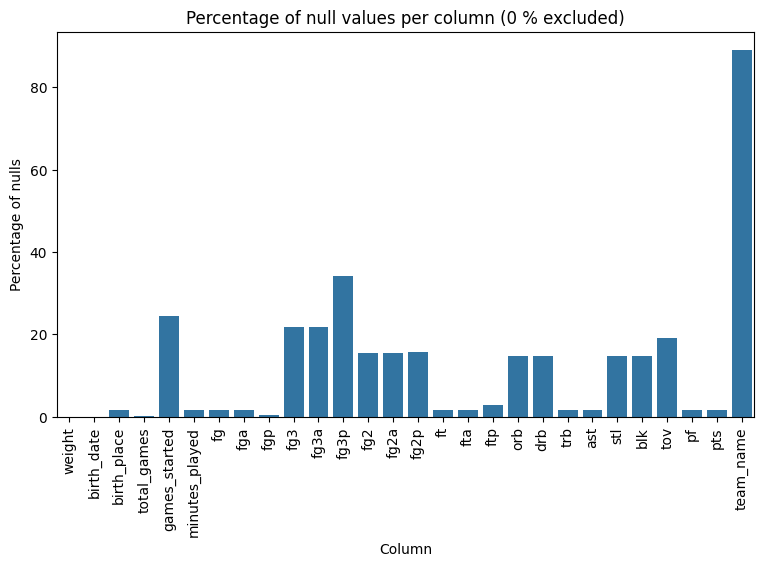

In [21]:
# don't visualize all columns that are zero as there is no need to visualise them
df_null_plot = df_merged.loc[:, df_merged.isnull().sum() != 0]
null_per_column = df_null_plot.isnull().sum()
percentage_per_column = null_per_column / len(df_null_plot) * 100
percentage_per_column.apply(lambda x: f"{np.round(x,2)} %")

plt.figure(figsize=(9, 5))
ax = sns.barplot(percentage_per_column)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("Percentage of nulls")
ax.set_xlabel("Column")
ax.set_title("Percentage of null values per column (0 % excluded)")

Text(0.5, 1.0, 'Heatmap of nulls per column (columns with zero nulls excluded)')

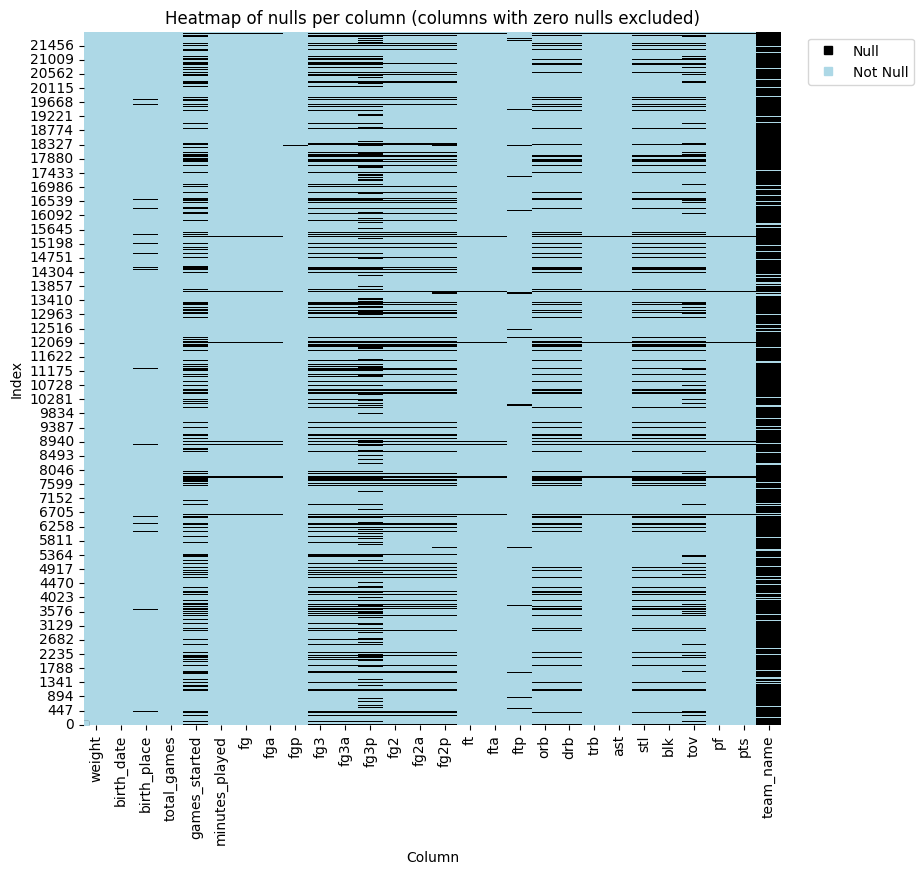

In [22]:
colors = ["lightblue", "black"]
plt.figure(figsize=(9, 9))
ax = sns.heatmap(df_null_plot.isnull(), cmap=colors, cbar=False)

plt.plot([0], label="Null", color=colors[1], marker="s", linestyle="")
plt.plot([0], label="Not Null", color=colors[0], marker="s", linestyle="")
legend = plt.legend(bbox_to_anchor=(1.2, 1))
ax.invert_yaxis()
ax.set_ylabel("Index")
ax.set_xlabel("Column")
ax.set_title("Heatmap of nulls per column (columns with zero nulls excluded)")

In [23]:
sct_data = df_merged[["minutes_played","fg", "fga", "fgp", "fg3", "fg3a", "fg3p", "fg2", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pf", "pts"]]
df = sct_data
scatter_matrix(df, alpha = 0.2, figsize = (20, 20), diagonal = 'kde')

NameError: name 'scatter_matrix' is not defined

In [ ]:
sct_data.corr()

,fg,fga,fgp,fg3,fg3a,fg3p,fg2,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pf,pts
fg,1.000000,0.805041,0.493183,0.143688,0.061681,0.098415,0.898025,0.388582,0.291632,0.239609,0.049819,0.031824,0.060940,0.085388,0.059930,-0.016035,0.180095,-0.169555,0.939773
fga,0.805041,1.000000,-0.035757,0.239877,0.282912,0.119932,0.685274,0.361471,0.271043,0.247240,-0.050173,-0.096548,-0.025914,0.139981,0.086130,-0.151335,0.230229,-0.154593,0.784466
fgp,0.493183,-0.035757,1.000000,-0.134620,-0.292537,-0.018915,0.522806,0.146661,0.131895,0.020818,0.213718,0.244419,0.207930,-0.070402,-0.049927,0.236994,-0.027767,-0.035516,0.425590
fg3,0.143688,0.239877,-0.134620,1.000000,0.897204,0.561005,-0.322597,-0.090465,-0.151776,0.286594,-0.421885,-0.256507,-0.379014,0.164402,0.023092,-0.281961,-0.117566,-0.306465,0.265904
fg3a,0.061681,0.282912,-0.292537,0.897204,1.000000,0.445406,-0.353946,-0.107974,-0.166826,0.273890,-0.456863,-0.266934,-0.403249,0.187587,0.049860,-0.315294,-0.106740,-0.317208,0.176967
fg3p,0.098415,0.119932,-0.018915,0.561005,0.445406,1.000000,-0.192735,-0.062854,-0.137703,0.226574,-0.389144,-0.228768,-0.321049,0.155028,0.026521,-0.261912,-0.093917,-0.267394,0.173088
fg2,0.898025,0.685274,0.522806,-0.322597,-0.353946,-0.192735,1.000000,0.413060,0.342191,0.100785,0.235026,0.147101,0.214781,0.032904,0.046868,0.109662,0.230608,-0.030051,0.785579
ft,0.388582,0.361471,0.146661,-0.090465,-0.107974,-0.062854,0.413060,1.000000,0.921379,0.273108,0.130064,0.059679,0.119884,0.078683,0.043674,0.009051,0.309158,-0.007467,0.636735
fta,0.291632,0.271043,0.131895,-0.151776,-0.166826,-0.137703,0.342191,0.921379,1.000000,-0.017193,0.246700,0.109659,0.208300,0.002205,0.011890,0.072788,0.326936,0.100565,0.523137
ftp,0.239609,0.247240,0.020818,0.286594,0.273890,0.226574,0.100785,0.273108,-0.017193,1.000000,-0.360409,-0.248409,-0.317703,0.254060,0.076352,-0.287192,0.004876,-0.310992,0.332843


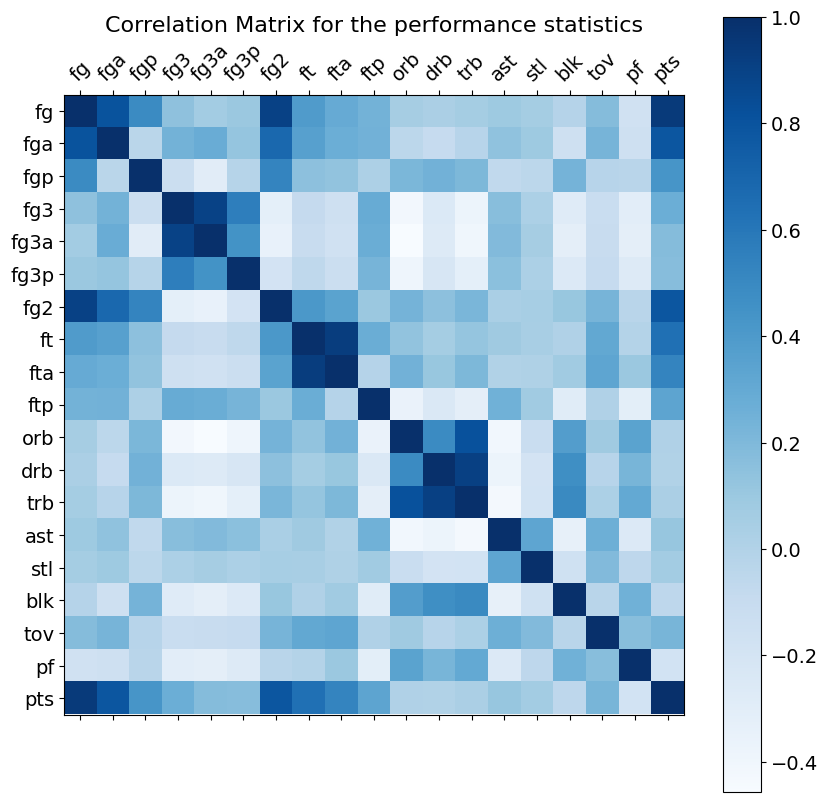

In [ ]:
f = plt.figure(figsize=(10, 10))
plt.matshow(sct_data.corr(), fignum=f.number, cmap=plt.get_cmap('Blues'))
plt.xticks(range(sct_data.select_dtypes(['number']).shape[1]), sct_data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(sct_data.select_dtypes(['number']).shape[1]), sct_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for the performance statistics', fontsize=16)
plt.show()

#### Handling Nulls in team_name

Missing value in the "team_name" means that the player currently has no team, since we chose "team_name" to represent only the current team of the player. Most cases can be explained by the "retired" column. So if the player is retired, their team will be assigned to "Retired". However, there are cases, in which a player is not retired but has no entry for the "current_team_id", so the missing values won't be handled by the default method.

As mentioned above, it is impossible to track, to which team each player belonged in which seasons, and for some cases, the "teams" column contains just an empty list. Judging by the "text" column that contains a short biography of each player, the players indeed played for some of the teams that are in the data, so assigning "Other" would be technically incorrect. Therefore, we decided to fill the other Nulls, of which there are relatively few, with "No Information".

There are no missing values in the "retired" column, so all cases must be covered accurately.

In [ ]:
# fill the missing team names for the retired players
df_merged.loc[df_merged["retired"], "team_name"] = "Retired"
print(
    f"Number of players that have no team and are not retired: {len(df_merged.loc[df_merged["team_name"].isna()])}"
)

# fill other missing team names
df_merged["team_name"].fillna("No Information", inplace=True)

Number of players that have no team and are not retired: 133


##### Handling the missing values in players' personal information
From the plot above we see that there are some entries where personal information of players such as weight, birth_date and birth_place are missing. 
We will handle them separately. 
- **weight**: there are no missing values in the "height" column, so we fill the missing values here with the average weight of the players' of the same height. For all different height values the corresponsing average weight values could be computed.
- **birth_date**: there is only one player with a missing birth_date, so we will fill his birth date manually.
- **birth_place**: this attribute is hard to fill accurately since it is a very specific piece of categorical data. There are also 331 misisng values, so it is not feasible to input them manually. Since we want to use the birth_place data for the visualization we would like it to be as accurate as possible. We noticed a pattern in the biographical "text" column that the first mention of a state is normally either a birth state or a high school state, where their basketball career begins. We will therefore fill the columns based on the first mentioned USA state. 

In [ ]:
# create a dictionary {height: average weight}
height_to_weight = (
    df_merged[["height_inches", "weight"]]
    .groupby("height_inches")["weight"]
    .mean()
    .to_dict()
)
# fill the missing values in the weight column with the computed averages
df_merged["weight"] = df_merged["weight"].fillna(
    df_merged["height_inches"].map(height_to_weight)
)

In [ ]:
# fill the only missing birth_date manually
df_merged["birth_date"].fillna(pd.to_datetime("1932-05-10"), inplace=True)

In [ ]:
df_merged.loc[df_merged["birth_place"].isna()]["text"]

67       Forest Edward "Frosty" Able (born July 27, 193...
80       Charles R. "Bud" Acton (born January 11, 1942 ...
216      Gary R. Alcorn (October 8, 1936 – November 29,...
217      Gary R. Alcorn (October 8, 1936 – November 29,...
267      Robert J. Allen (born July 17, 1946) is an Ame...
                               ...                        
21779    Wayne Yates (born November 7, 1937) is a retir...
21854    David A. Zeller (born June 8, 1939) is a forme...
21855    Gary Lynn Zeller (November 20, 1947 – February...
21856    Gary Lynn Zeller (November 20, 1947 – February...
21883    William Charles Zopf (born June 7, 1948) is a ...
Name: text, Length: 331, dtype: object

#### Handling the missing values in performance statistics

#### Final check

Plot the same heatmap as above to see the impact of the Null-handling methods.

Text(0.5, 1.0, 'Heatmap of nulls per column (columns with zero nulls excluded)')

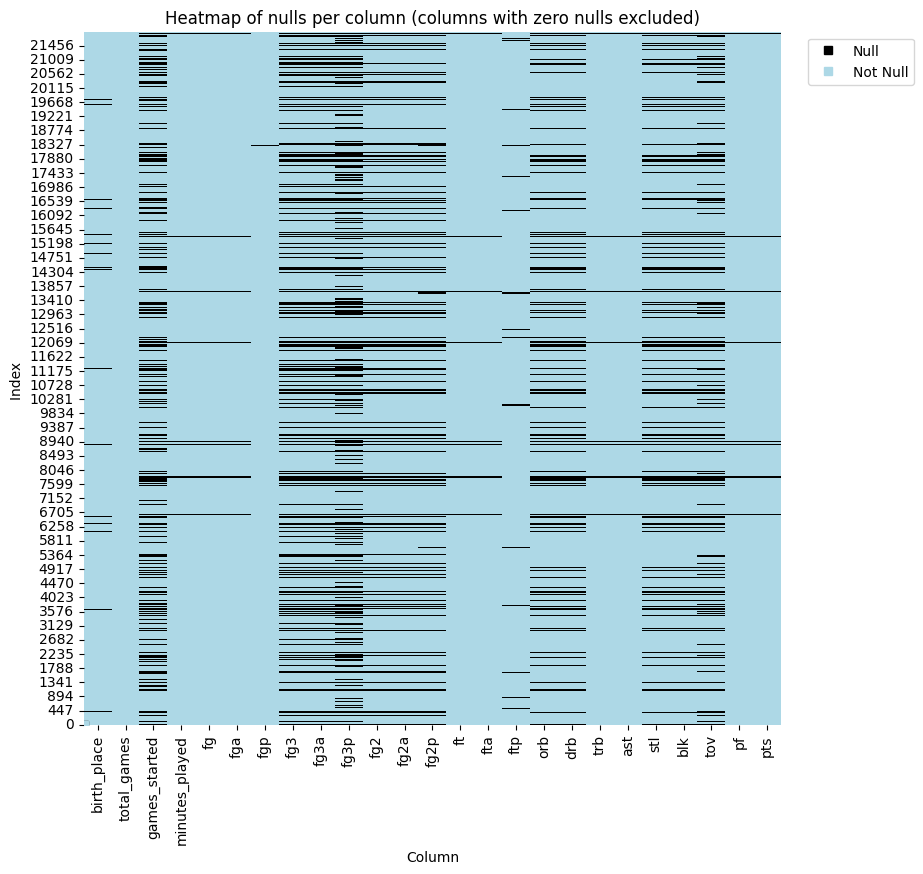

In [ ]:
df_null_plot = df_merged.loc[:, df_merged.isnull().sum() != 0]
colors = ["lightblue", "black"]
plt.figure(figsize=(9, 9))
ax = sns.heatmap(df_null_plot.isnull(), cmap=colors, cbar=False)

plt.plot([0], label="Null", color=colors[1], marker="s", linestyle="")
plt.plot([0], label="Not Null", color=colors[0], marker="s", linestyle="")
legend = plt.legend(bbox_to_anchor=(1.2, 1))
ax.invert_yaxis()
ax.set_ylabel("Index ")
ax.set_xlabel("Column")
ax.set_title("Heatmap of nulls per column (columns with zero nulls excluded)")

## Creating grouped tables
Create two new tables: one that groups rows based on player_id, another that groups rows based on team_id.

### Group by Player ID

#### While exploring the dataset we found that some players have two player-ids. This has to be fixed, as this id has to be unique for every player. 

Check for players which have two different player ids

In [ ]:
def get_players_with_two_ids():
    df_players_with_two_ids = df_merged.copy()
    df_players_with_two_ids = df_players_with_two_ids.drop_duplicates(
        subset=["player_id"]
    )
    array_player_names_with_two_ids = df_players_with_two_ids[
        df_players_with_two_ids.duplicated(subset=["full_name"])
    ]["full_name"].unique()
    df_players_with_two_ids = df_players_with_two_ids[
        df_players_with_two_ids["full_name"].isin(array_player_names_with_two_ids)
    ].sort_values("full_name")
    return df_players_with_two_ids


df_players_with_two_ids = get_players_with_two_ids()
df_players_with_two_ids

,name,full_name,position,weight,birth_date,birth_place,retired,teams,text,player_id,...,drb,trb,ast,stl,blk,tov,pf,pts,team_name,height_inches
21713,Chris Wright,Chris Wright,F,226.0,1988-09-30,"Trotwood, Ohio",True,"[10, 17]","Chris Wright (born September 30, 1988) is an A...",4740,...,2.9,5.7,1.4,2.0,1.4,1.4,4.9,13.7,Retired,80
21715,Chris Wright,Chris Wright,G,210.0,1989-11-04,"Washington, District of Columbia",True,[],"Chris Wright (born November 4, 1989) is an Ame...",4741,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,18.0,Retired,73
16796,Isaiah Roby,Isaiah Roby,F,230.0,1998-02-03,"Dixon, Illinois",False,[21],"Isaiah Roby (born February 3, 1998) is an Amer...",3643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oklahoma City Thunder,80
21888,Isaiah Roby,Isaiah Roby,F,230.0,1998-02-03,"Dixon, Illinois",False,"[7, 21]","Isaiah Roby (born February 3, 1998) is an Amer...",4811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oklahoma City Thunder,80
12516,Jeremiah Martin,Jeremiah Martin,G,184.0,1996-06-19,"Memphis, Tennessee",False,[3],"Jeremiah Martin (born June 19, 1996) is an Ame...",2702,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,75
21890,Jeremiah Martin,Jeremiah Martin,PG,184.0,1996-01-19,"Memphis, Tennessee",False,[3],"Jeremiah Martin (born June 19, 1996) is an Ame...",4817,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,75
17708,Marial Shayok,Marial Shayok,G,196.0,1995-07-26,"Ottawa, Canada",False,[23],"Marial Makur Shayok (born July 26, 1995) is a ...",3851,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Philadelphia 76ers,77
21889,Marial Shayok,Marial Shayok,G,196.0,1995-07-26,"Ottawa, Canada",False,[29],"Marial Makur Shayok (born July 26, 1995) is a ...",4814,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Utah Jazz,77
1940,Marques Bolden,Marques Terrell Bolden,C,245.0,1998-04-17,"Dallas, Texas",False,[6],"Marques Terrell Bolden (born April 17, 1998) i...",387,...,24.0,24.0,0.0,12.0,0.0,0.0,12.0,0.0,Cleveland Cavaliers,83
21893,Marques Bolden,Marques Terrell Bolden,C,245.0,1998-04-17,"Dallas, Texas",False,[6],"Marques Terrell Bolden (born April 17, 1998) i...",4820,...,24.0,24.0,0.0,12.0,0.0,0.0,12.0,0.0,Cleveland Cavaliers,83


Rename the first Walter Jones as he is named incorrectly in the dataset

In [ ]:
df_merged.loc[
    (df_merged["full_name"] == "Walter Jones") & (df_merged["position"] == "G-F"),
    "full_name",
] = "Larry Jones"
df_players_with_two_ids = get_players_with_two_ids()
df_players_with_two_ids

,name,full_name,position,weight,birth_date,birth_place,retired,teams,text,player_id,...,drb,trb,ast,stl,blk,tov,pf,pts,team_name,height_inches
21713,Chris Wright,Chris Wright,F,226.0,1988-09-30,"Trotwood, Ohio",True,"[10, 17]","Chris Wright (born September 30, 1988) is an A...",4740,...,2.9,5.7,1.4,2.0,1.4,1.4,4.9,13.7,Retired,80
21715,Chris Wright,Chris Wright,G,210.0,1989-11-04,"Washington, District of Columbia",True,[],"Chris Wright (born November 4, 1989) is an Ame...",4741,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,18.0,Retired,73
16796,Isaiah Roby,Isaiah Roby,F,230.0,1998-02-03,"Dixon, Illinois",False,[21],"Isaiah Roby (born February 3, 1998) is an Amer...",3643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oklahoma City Thunder,80
21888,Isaiah Roby,Isaiah Roby,F,230.0,1998-02-03,"Dixon, Illinois",False,"[7, 21]","Isaiah Roby (born February 3, 1998) is an Amer...",4811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oklahoma City Thunder,80
12516,Jeremiah Martin,Jeremiah Martin,G,184.0,1996-06-19,"Memphis, Tennessee",False,[3],"Jeremiah Martin (born June 19, 1996) is an Ame...",2702,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,75
21890,Jeremiah Martin,Jeremiah Martin,PG,184.0,1996-01-19,"Memphis, Tennessee",False,[3],"Jeremiah Martin (born June 19, 1996) is an Ame...",4817,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,75
17708,Marial Shayok,Marial Shayok,G,196.0,1995-07-26,"Ottawa, Canada",False,[23],"Marial Makur Shayok (born July 26, 1995) is a ...",3851,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Philadelphia 76ers,77
21889,Marial Shayok,Marial Shayok,G,196.0,1995-07-26,"Ottawa, Canada",False,[29],"Marial Makur Shayok (born July 26, 1995) is a ...",4814,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Utah Jazz,77
1940,Marques Bolden,Marques Terrell Bolden,C,245.0,1998-04-17,"Dallas, Texas",False,[6],"Marques Terrell Bolden (born April 17, 1998) i...",387,...,24.0,24.0,0.0,12.0,0.0,0.0,12.0,0.0,Cleveland Cavaliers,83
21893,Marques Bolden,Marques Terrell Bolden,C,245.0,1998-04-17,"Dallas, Texas",False,[6],"Marques Terrell Bolden (born April 17, 1998) i...",4820,...,24.0,24.0,0.0,12.0,0.0,0.0,12.0,0.0,Cleveland Cavaliers,83


Decide for each player individually how to merge the two player instances:

- Ignore Chris Wrights and Micheal John Smith as they are obviously different persons

- Isaiah Roby: Drop the first entry as it's containing less info (teams)

- Jeremiah Martin: According to his wikipedia he played as PG in 2019-20. The position of the first entry will be changed and the second entry (has the wrong birth date), will be dropped.

- Marial Shayhok: According to the [NBA-Website](https://www.nba.com/stats/player/1629621/career) he only played for Philadelphia that season, so that row stays

- Marques Terrell Bolden: Same info in both rows. First one stays

- William Howard: Drop the first entry as it's containing less info (teams)


In [ ]:
df_merged = df_merged.loc[~(df_merged["player_id"] == 3643)]
df_merged = df_merged.loc[~(df_merged["player_id"] == 4817)]
df_merged.loc[df_merged["player_id"] == 2702, "position"] = "PG"
df_merged = df_merged.loc[~(df_merged["player_id"] == 3851)]
df_merged = df_merged.loc[~(df_merged["player_id"] == 4820)]
df_merged = df_merged.loc[~(df_merged["player_id"] == 1951)]


get_players_with_two_ids()

,name,full_name,position,weight,birth_date,birth_place,retired,teams,text,player_id,...,drb,trb,ast,stl,blk,tov,pf,pts,team_name,height_inches
21713,Chris Wright,Chris Wright,F,226.0,1988-09-30,"Trotwood, Ohio",True,"[10, 17]","Chris Wright (born September 30, 1988) is an A...",4740,...,2.9,5.7,1.4,2.0,1.4,1.4,4.9,13.7,Retired,80
21715,Chris Wright,Chris Wright,G,210.0,1989-11-04,"Washington, District of Columbia",True,[],"Chris Wright (born November 4, 1989) is an Ame...",4741,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,18.0,Retired,73
18199,Michael Smith,Michael John Smith,F,225.0,1965-05-19,"Rochester, New York",True,"[2, 13]","Michael John Smith (born May 19, 1965) is a re...",3973,...,3.2,5.2,4.0,0.6,0.2,3.4,2.5,20.2,Retired,82
18202,Michael Smith,Michael John Smith,F,230.0,1972-03-28,"Washington, District of Columbia",True,"[26, 30]","Michael John Smith (born March 28, 1972) is an...",3974,...,6.4,10.1,2.9,1.2,1.2,1.9,4.3,9.3,Retired,80


Select the most important scoring stats for all players. Calculate the mean scoring stats over their whole career. This is done to only have a small subset of the stats, which can be easily compared even with low basketball knowledge

In [ ]:
scoring_agg = {
    "name": ["min"],
    "team_name": ["min"],
    "fg3": [lambda x: np.mean(x) * 3],  # convert this stats to points scale
    "fg2": [lambda x: np.mean(x) * 2],  # convert this stats to points scale
    "ft": ["mean"],  # stat is already in the points scale
    "pts": ["mean"],  # stat is already in the points scale
}

df_player_scoring_stats = (
    df_merged.groupby(["player_id"]).agg(scoring_agg).reset_index(drop=True)
)
df_player_scoring_stats.columns = df_player_scoring_stats.columns.get_level_values(0)

columns_with_numbers = df_player_scoring_stats.columns[2:]

- Choose the top 5 all-time leading scorers based on data from: https://www.nba.com/stats/alltime-leaders. This selection aids in addressing the ongoing debate surrounding the GOAT (Greatest of All Time) in basketball. Additionally, a smaller number of players results in a less cluttered plot.
- Calculate the averages for the entire data set to determine the average performance of players in NBA history and provide a basis for comparing the top 5 to an average player.

In [ ]:
top_scorers = [
    "LeBron James",
    "Kareem Abdul-Jabbar",
    "Karl Malone",
    "Kobe Bryant",
    "Michael Jordan",
]

df_to_plot_pcp = df_player_scoring_stats[
    df_player_scoring_stats["name"].isin(top_scorers)
].sort_values("pts")


mean_per_column = df_player_scoring_stats[columns_with_numbers].mean()
mean_df = pd.DataFrame([mean_per_column.values], columns=mean_per_column.index)
mean_df["name"] = "Player Average"

### Group by team name (team id)

Create a grouped DataFrame by team and season. Calculate the average points per 36 mins

In [ ]:
teams_agg = {
    "pts": ["mean"],
}

df_teams = df_merged.groupby(["team_name", "season"]).agg(teams_agg).reset_index()
df_teams.columns = df_teams.columns.get_level_values(0)

Select only the latest season. This is necessary for linking a player's performance with their team's performance, which is feasible only for the most recent season. Typically, the current team corresponds to the team the player played for in the last season. However, there are occasional instances of players switching teams mid-season, which will be tolerated and not addressed further for the purpose of this exercise.

Additionally, exclude entries labeled as "Retired" or "No Information."

In [ ]:
df_teams = (
    df_teams[df_teams["season"] == "2019-20"]
    .drop(columns="season")
    .reset_index(drop=True)
)

list_to_drop = ["Retired", "No Information"]
df_teams = df_teams[~df_teams["team_name"].isin(list_to_drop)]

### Plot graph based on player id

Create a parallel coordinates plot to illustrate the scoring performance across various statistics for the top 5 scorers of all time. This is done via pandas plotting which builds on top of matplotlib. Therefore all matplotlib functioncs can be used to manipulate the plot

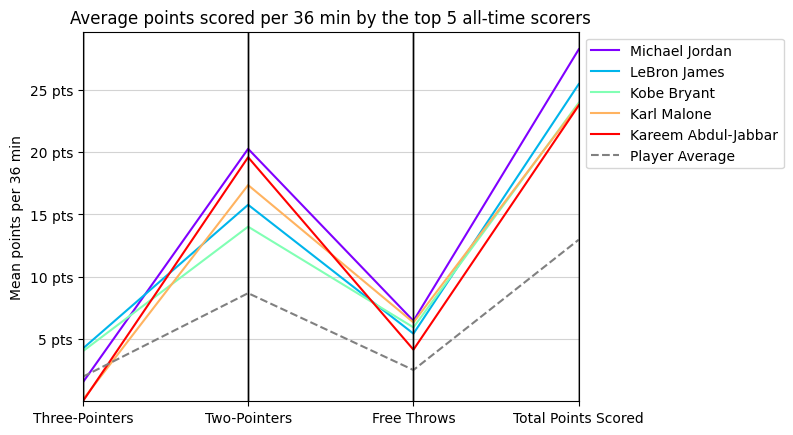

In [ ]:
df_to_plot_pcp = df_player_scoring_stats[
    df_player_scoring_stats["name"].isin(top_scorers)
]

df_to_plot_pcp = df_to_plot_pcp.sort_values("pts", ascending=False)
df_to_plot_pcp = df_to_plot_pcp.drop(columns="team_name")
ax = pd.plotting.parallel_coordinates(df_to_plot_pcp, "name", colormap="rainbow")
pd.plotting.parallel_coordinates(mean_df, "name", color="gray", linestyle="--")

ax.grid(axis="y", color="lightgray")

ax.set_xticklabels(
    ["Three-Pointers", "Two-Pointers", "Free Throws", "Total Points Scored"]
)

formatter = plt.FuncFormatter(
    lambda x, _: f"{int(x)} pts"
)  # Formatter to add "pts" to y tick labels
ax.yaxis.set_major_formatter(formatter)

ax.set_ylim(bottom=0.01)  # 0 Pts will not be plotted.
ax.legend(bbox_to_anchor=(1, 1))
ax.set_ylabel("Mean points per 36 min")
ax.set_title("Average points scored per 36 min by the top 5 all-time scorers")
plt.show()

Description of the plot:
- The plot illustrates the top 5 all-time scorers in the NBA, detailing their average points per 36 minutes across different scoring methods. Additionally, it includes the average performance of NBA players for comparison.

- Across the board, the bulk of points for these top players comes from Two-Pointers, followed by Free Throws, and then Three-Pointers, indicating a consistent trend among them.

- The graph illustrates the points scored per 36 minutes and the breakdown of scoring methods for the top 5 all-time scorers, averaged across each player's entire career.

- Michael Jordan appears to be the greatest scorer per 36 minutes of all time. However, he is only an average three-point shooter, excelling instead at two-pointers and free throws.

- Kareem Abdul-Jabbar and Karl Malone are both terrible three-point shooters, falling well below average. 

- Kareem Abdul-Jabbar's real strength seems to be two-pointers, where he is very close to Michael Jordan.

- LeBron James seems like a great all-rounder. His three-pointers are the best among the top 5, and in no category is he the worst player. 

- Kobe Bryant is also a great three-point shooter, but compared to the others, his weakness lies in two-pointers.


### Plot graph based on team name (team_id)

In [ ]:
# Dict to map the primary colors to the team names
nba_team_primary_colors = {
    "Atlanta Hawks": "#E03A3E",
    "Boston Celtics": "#007A33",
    "Brooklyn Nets": "#000000",
    "Charlotte Hornets": "#00788C",
    "Chicago Bulls": "#CE1141",
    "Cleveland Cavaliers": "#860038",
    "Dallas Mavericks": "#00538C",
    "Denver Nuggets": "#0E2240",
    "Detroit Pistons": "#C8102E",
    "Golden State Warriors": "#1D428A",
    "Houston Rockets": "#CE1141",
    "Indiana Pacers": "#002D62",
    "Los Angeles Clippers": "#C8102E",
    "Los Angeles Lakers": "#552583",
    "Memphis Grizzlies": "#5D76A9",
    "Miami Heat": "#98002E",
    "Milwaukee Bucks": "#00471B",
    "Minnesota Timberwolves": "#0C2340",
    "New Orleans Pelicans": "#0C2340",
    "New York Knicks": "#006BB6",
    "Oklahoma City Thunder": "#007AC1",
    "Orlando Magic": "#0077C0",
    "Philadelphia 76ers": "#006BB6",
    "Phoenix Suns": "#1D1160",
    "Portland Trail Blazers": "#E03A3E",
    "Sacramento Kings": "#5A2D81",
    "San Antonio Spurs": "#C4CED4",
    "Toronto Raptors": "#CE1141",
    "Utah Jazz": "#002B5C",
    "Washington Wizards": "#002B5C",
}

#Dict to map the short names to the team names
nba_teams_short = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BKN",
    "Charlotte Hornets": "CHA",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHX",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS",
}


# Create a new column for the mapping
df_teams["color"] = df_teams["team_name"].map(nba_team_primary_colors)
df_teams["short_team_names"] = df_teams["team_name"].map(nba_teams_short)

# Create a column which contains the legend entries
df_teams["legend"] = df_teams["short_team_names"] + " - " + df_teams["team_name"]

# Sort DataFrame
df_teams = df_teams.sort_values("pts", ascending=False)


# Define the source
source = ColumnDataSource(data=df_teams)

# Define the figure
p = figure(
    title="Average Points per Player per 36 Minutes per Team in the 2019-20 NBA Season",
    x_range=df_teams["short_team_names"],
    height=800,
    width=1100,
)


# Create a ColorMapper to map the primary colors to bars
color_mapper = CategoricalColorMapper(
    factors=df_teams["team_name"].unique(), palette=df_teams["color"]
)

# Add a legend. Important to have that bit before the p.vbar. Otherwise legend will be on top of plot
p.add_layout(Legend(), "right")

# Plot bar plot
p.vbar(
    x="short_team_names",
    top="pts",
    width=0.5,
    bottom=0,
    source=source,
    color={"field": "team_name", "transform": color_mapper},
    legend_field="legend",
)

# Create a hovering tool
hover = HoverTool(tooltips=[("Team", "@team_name"), ("Points", "@pts")])
p.add_tools(hover)

# Adjust the legend
p.legend.label_text_font_size = "9pt"
p.legend.glyph_height = 10
p.legend.glyph_width = 10

# Adjust the y starting valze
p.y_range.start = 0

p.xaxis.major_label_orientation = 120

# Add a format to the y-ticks
p.yaxis.formatter = tick_formatter = CustomJSTickFormatter(
    code="""
    return tick + " pts";
    """
)


# Plot the graph
output_notebook()
show(p)

Loading BokehJS ...

Description:
- The graph illustrates the average points per player per 36 minutes per team during the 2019-20 Season.

- It is interactive; hovering over it displays the full team name and the precise average points.

- The color of the bar corresponds to the primary color of the team

- The bar chart is arranged in descending order from the highest average to the lowest.

- On average, the Los Angeles Clippers' coach could anticipate their players scoring more points in 36 minutes than any other team. Moreover, the gap to the second-ranked team is significant at 1.5 points.

- However, it wasn't the Los Angeles Clippers but rather the Los Angeles Lakers who were the champions that year, despite having the third worst average. The Miami Heat, the second finalist, only ranked 20th in terms of average points per player per 36 minutes. This indicates that there is no clear correlation between a team's average performance per player per 36 minutes and their success in the championship.

## Data visualisation
Visualize the data (twice). Every submitted notebook should contain at least two visualizations using at least two different Python visualization libraries. One visualization for each of the new tables (aggregated players or aggregated teams). A list of the most wide-spread Python visualization libraries can be found in this article. You must concisely describe and explain each visualization and your decisions in a Markdown field. You will not receive the points for this task if you did not add a description/explanation. 

# Sasha

In [ ]:
birth_places = df_merged["birth_place"].unique()

In [ ]:
df_merged["birth_states"] = df_merged["birth_place"].str.split(",", expand=True)[1]
df_merged["birth_states"] = df_merged["birth_states"].apply(
    lambda x: str(x).replace("\xa0", "")
)

In [ ]:
all_states = pd.Series(df_merged["birth_states"].unique())

In [ ]:
US_states = [
    "Alabama",
    "Alaska",
    "Arizona",
    "Arkansas",
    "California",
    "Colorado",
    "Connecticut",
    "Delaware",
    "Florida",
    "Georgia",
    "Hawaii",
    "Idaho",
    "Illinois",
    "Indiana",
    "Iowa",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Maine",
    "Maryland",
    "Massachusetts",
    "Michigan",
    "Minnesota",
    "Mississippi",
    "Missouri",
    "Montana",
    "Nebraska",
    "Nevada",
    "New Hampshire",
    "New Jersey",
    "New Mexico",
    "New York",
    "North Carolina",
    "North Dakota",
    "Ohio",
    "Oklahoma",
    "Oregon",
    "Pennsylvania",
    "Rhode Island",
    "South Carolina",
    "South Dakota",
    "Tennessee",
    "Texas",
    "Utah",
    "Vermont",
    "Virginia",
    "Washington",
    "West Virginia",
    "Wisconsin",
    "Wyoming",
]

US_state_to_code = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

In [ ]:
df_merged_US = df_merged.loc[df_merged["birth_states"].isin(US_states)]
df_merged_US["state_code"] = df_merged_US["birth_states"].map(US_state_to_code)

In [ ]:
np.setdiff1d(US_states, all_states[pd.Series(all_states).isin(US_states)].unique())

array(['Vermont'], dtype='<U14')

In [ ]:
df_merged_US_map = (
    df_merged_US[["birth_states", "state_code", "player_id"]]
    .groupby(["state_code", "birth_states"])
    .count()
    .reset_index()
)

In [ ]:
# add Vermont to the table for completeness
df_merged_US_map = pd.concat(
    [
        df_merged_US_map,
        pd.DataFrame([{"state_code": "VT", "birth_states": "Vermont", "player_id": 0}]),
    ],
    ignore_index=True,
)

In [ ]:
fig = px.choropleth(
    df_merged_US_map,
    locations="state_code",
    locationmode="USA-states",
    scope="usa",
    color="player_id",
    color_continuous_scale="Blues",
    hover_name="birth_states",
)

fig.update_layout(geo=dict(showlakes=False))

fig.add_scattergeo(
    locations=df_merged_US_map["state_code"],
    locationmode="USA-states",
    text=df_merged_US_map["state_code"],
    mode="text",
    hoverinfo="skip",
)

fig.update_layout(
    title={
        "text": "Number of NBA players born in each US state",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    }
)

## Saving the results
Save the resulting tables (the cleaned player_data_per_36_min and the two new aggregated tables) as CSV. To be sure that the data is correctly saved, you can load it again. You will have to work with these tables for the second exercise.